# Funções

In [1]:
import time

#-----------------------------------------------------------------------------------
#  Função que plota o CAPPI das variáveis polarimétricas Z, ZDR, KDP, COR e VEL
#-----------------------------------------------------------------------------------
def quicklook_cappi_z_zdr_kdp_cor_vel(fileout, ds):

    # importa bibliotecas
    import matplotlib.pyplot as plt
    import cartopy.crs as ccrs  

    # define o tamanho da figura
    fig = plt.figure(figsize=(9,9))

    # Z
    ax1 = plt.subplot(321)
    ds['corrected_reflectivity'][0,0,:,:].plot(cmap='pyart_NWSRef', vmin=0, vmax=70, ax=ax1)

    # ZDR
    ax2 = plt.subplot(322)
    ds['corrected_differential_reflectivity'][0,0,:,:].plot(cmap='coolwarm', vmin=-2, vmax=6, ax=ax2)

    # KDP
    ax3 = plt.subplot(323)
    ds['specific_differential_phase'][0,0,:,:].plot(cmap='coolwarm', vmin=-2, vmax=6, ax=ax3)

    # COR
    ax4 = plt.subplot(324)
    ds['cross_correlation_ratio'][0,0,:,:].plot(cmap='jet', vmin=0.7, vmax=1.0, ax=ax4)

    # VEL
    ax5 = plt.subplot(325)
    ds['corrected_velocity'][0,0,:,:].plot(cmap='coolwarm', vmin=-20, vmax=20, ax=ax5)

    # recorta figura
    plt.tight_layout()

    # salva figura
    plt.savefig(fileout, dpi=300)
    print('...... 6. Plotou quicklook das variáveis polarimétricas')

#-----------------------------------------------------------------------------------
#                   Função que plota o CAPPI da precipitação
#-----------------------------------------------------------------------------------
def quicklook_cappi_rainrate(fileout, ds):

    # importa bibliotecas
    import matplotlib.pyplot as plt
    import cartopy.crs as ccrs  

    # define o tamanho da figura
    fig = plt.figure(figsize=(11,9))

    # Z
    ax1 = plt.subplot(221)
    ds['rainrate_z'][0,0,:,:].plot(cmap='pyart_LangRainbow12', vmin=1, vmax=50, ax=ax1)

    # KDP
    ax2 = plt.subplot(222)
    ds['rainrate_kdp'][0,0,:,:].plot(cmap='pyart_LangRainbow12', vmin=1, vmax=50, ax=ax2)

    # Z-KDP
    ax3 = plt.subplot(223)
    ds['rainrate_z_kdp'][0,0,:,:].plot(cmap='pyart_LangRainbow12', vmin=1, vmax=50, ax=ax3)

    # Z-ZDR-KDP
    ax4 = plt.subplot(224)
    ds['rainrate_z_zdr_kdp'][0,0,:,:].plot(cmap='pyart_LangRainbow12', vmin=1, vmax=50, ax=ax4)

    # recorta figura
    plt.tight_layout()

    # salva figura
    plt.savefig(fileout, dpi=300)
    print('...... 7. Plotou quicklook da precipitação \n')

# Processamento

- Existem diversas relações para calcular a precipitação através das variáveis fornecidas pelo radar. Usaremos como exemplo aquelas [fornecidas](https://arm-doe.github.io/pyart/API/generated/pyart.retrieve.html) pelo Py-ART. Utilizaremos três relações:

    1. [retrieve.est_rain_rate_z](https://arm-doe.github.io/pyart/API/generated/pyart.retrieve.est_rain_rate_z.html): estima a precipitação através de Lei de potência com a refletividade (`Z-R`).

    2. [retrieve.est_rain_rate_kdp](https://arm-doe.github.io/pyart/API/generated/pyart.retrieve.est_rain_rate_kdp.html): estima a precipitação através da Lei de potência com o KDP (`KDP-R`).  
   
    3. [retrieve.est_rain_rate_zkdp](https://arm-doe.github.io/pyart-docs-travis/API/generated/pyart.retrieve.est_rain_rate_zkdp.html): estima a precipitação através da combinação da Lei de potência com a chuva-KDP e chuva-refletividade (`KDP-Z-R`).` e `
 
    4. Calcula a precipitação utilizando uma relação Z-ZDR-KDP para radar Banda-S - [Ryzhkov et al (2005)](https://journals.ametsoc.org/view/journals/apme/44/4/jam2213.1.xml). Nessa formulação iremos utilizar Z, ZDR e KDP para estimar a precipitação, como explicado a seguir:
 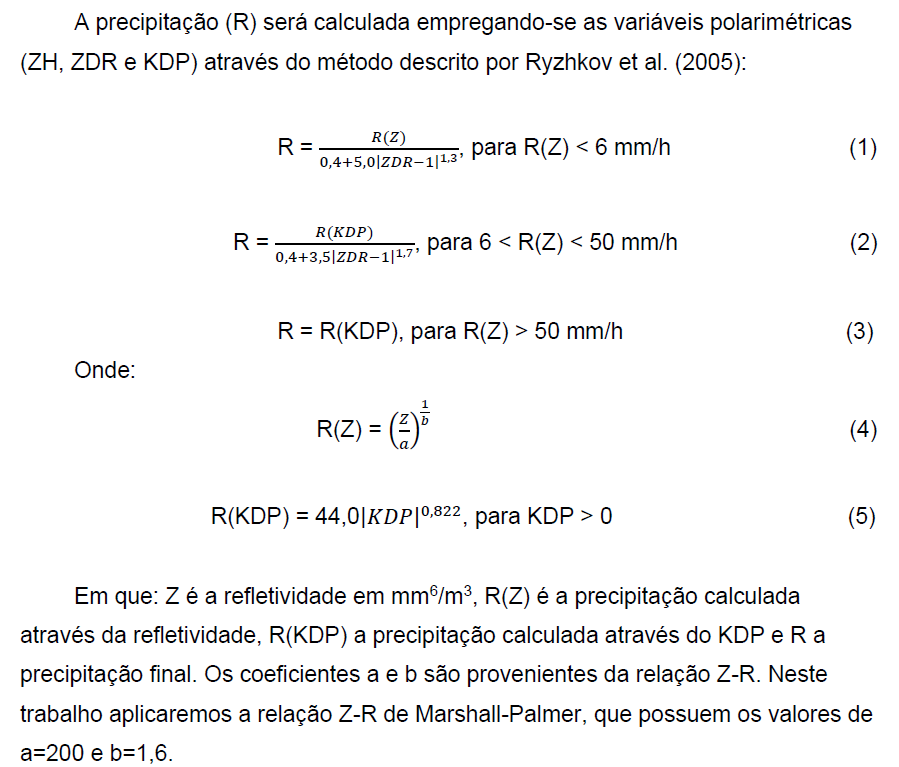      Z-R`).

In [ ]:
%%time
#========================================================================================================================#
#                                              IMPORTAÇÃO DAS BIBLIOTECAS
#========================================================================================================================#
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import pyart
import pandas as pd
import numpy as np
import glob
from datetime import datetime
import xarray as xr
import warnings
warnings.filterwarnings("ignore")

#========================================================================================================================#
#                                                 DIRETÓRIOS
#========================================================================================================================#
dir_input = 'VOLUMETRICOS/'
dir_output = '/Users/enriq/Downloads/PROCESSAMENTO_PYTHON/ARTIGO_LITORAL_NORTE_2023/output/04_NETCDF_CAPPI/'

#========================================================================================================================#
#                                                 LISTA DOS ARQUIVOS
#========================================================================================================================#
files = sorted(glob.glob(f'{dir_input}PNOVA2-2*HDF5')) # PNOVA2-20230218000002.HDF5
#files = files[0:13]

#========================================================================================================================#
#                                                 PROCESSAMENTO
#========================================================================================================================#
for file in files:

    print('PROCESSANDO ===>>', file)

    #--------------------------------------------------------------#
    #                     LEITURA DO DADO
    #--------------------------------------------------------------#
    # leitura do arquivo
    radar = pyart.aux_io.read_gamic(f'{file}')
    
    # extrai a data e horário do radar
    ano = str(pyart.util.datetime_from_grid(radar).year)
    mes = str(pyart.util.datetime_from_grid(radar).month).zfill(2)
    dia = str(pyart.util.datetime_from_grid(radar).day).zfill(2)
    hor = str(pyart.util.datetime_from_grid(radar).hour).zfill(2)
    min = str(pyart.util.datetime_from_grid(radar).minute).zfill(2)
    seg = str(pyart.util.datetime_from_grid(radar).second).zfill(2)

    # extrai a latitude, longitude e altitude do radar
    lat_radar, lon_radar = radar.latitude['data'][0], radar.longitude['data'][0]
    altitude = radar.altitude['data'][0]
    #variaveis = pd.DataFrame(list(radar.fields))
    #print(variaveis)
    print('...... 1. Extraiu informações da data')
        
    #--------------------------------------------------------------#
    #                  CALCULA PRECIPITAÇÃO
    #--------------------------------------------------------------#
    # a) Z-R
    chuva_z = pyart.retrieve.est_rain_rate_z(radar, refl_field='corrected_reflectivity')

    # b) KDP-R
    chuva_kdp = pyart.retrieve.est_rain_rate_kdp(radar, kdp_field='specific_differential_phase')

    # c) Z-R e KDP-R
    chuva_z_kdp = pyart.retrieve.est_rain_rate_zkdp(radar, refl_field='corrected_reflectivity', kdp_field='specific_differential_phase', thresh_max=True, thresh=40)

    # adiciona os campos criados na estrutura do objeto "radar"
    radar.add_field('rainrate_z', chuva_z)
    radar.add_field('rainrate_kdp', chuva_kdp)
    radar.add_field('rainrate_z_kdp', chuva_z_kdp)

    # d) Z-ZDR-KDP
    # guarda os campos de cada variável
    refl = radar.fields['corrected_reflectivity']['data']
    zdr = radar.fields['corrected_differential_reflectivity']['data']
    kdp = radar.fields['specific_differential_phase']['data']
    
    # chuva usando somente KDP
    rkdp = 44.0 * np.ma.power(abs(kdp), 0.822)
    
    # Marshall Palmer para Z-R
    z = np.ma.power(10.0, refl/10)
    r_zr = (np.ma.power(z/200, 1/1.6))
    
    # copia o campo r_zr como matriz de saida
    rain = r_zr
    
    # agora verifica os limiares para uso com Z-ZDR-KDP
    idx = np.where(r_zr <= 6)
    rain[idx] = r_zr[idx] / (0.4 + 5.0 * np.ma.power(abs(zdr[idx] - 1), 1.3))
    
    idx = np.where(r_zr > 6)
    rain[idx] = rkdp[idx] / (0.4 + 3.5 * np.ma.power(abs(zdr[idx] - 1), 1.7))
    
    idx = np.where(r_zr > 50)
    rain[idx] = rkdp[idx]
    
    # adiciona o campo de precipitação
    radar.add_field_like('corrected_reflectivity', 'rainrate_z_zdr_kdp', rain)
    radar.fields['rainrate_z_zdr_kdp']['units'] = 'mm/h'
    radar.fields['rainrate_z_zdr_kdp']['standard_name'] = 'Rain_Rate'
    radar.fields['rainrate_z_zdr_kdp']['long_name'] = 'Rain Rate'
    print('...... 2. Calculou campo de taxa de precipitação')
    
    #--------------------------------------------------------------#
    #                      GERA CAPPI
    #--------------------------------------------------------------#
    cappi = pyart.map.grid_from_radars(radar,
                                       grid_shape=(13, 500, 500),
                                       grid_limits=((3000 - altitude, 15000 - altitude),
                                                    (-250_000., 250_000.),
                                                    (-250_000., 250_000.)),
                                       grid_origin = (lat_radar, lon_radar),
                                       gridding_algo='map_gates_to_grid',
                                       roi_func='dist_beam', min_radius=2000.0,
                                       weighting_function='Nearest',
                                       fields=['corrected_reflectivity', 'corrected_differential_reflectivity', 'specific_differential_phase', 'cross_correlation_ratio',
                                               'corrected_velocity',
                                               'rainrate_z', 'rainrate_kdp', 'rainrate_z_kdp', 'rainrate_z_zdr_kdp'])
    print('...... 3. Gerou CAPPI')
     
    #-------------------------------------------------------#
    #           SALVA ARQUIVO NO FORMATO NETCDF
    #-------------------------------------------------------#
    # transforma para Xarray
    cappi_dataset = cappi.to_xarray() # cappi_3d = np.zeros((z_grid_points, y_grid_points, x_grid_points)) # cappi_3d[alturas, latitudes, longitudes])
    print('...... 4. Transformou para DataSet')

    # transforma o dataset para array: (time, z, y, x)
    rainrate_z_values = cappi_dataset['rainrate_z'][0,:,:,:].values
    rainrate_kdp_values = cappi_dataset['rainrate_kdp'][0,:,:,:].values
    rainrate_z_kdp_values = cappi_dataset['rainrate_z_kdp'][0,:,:,:].values
    rainrate_z_zdr_kdp_values = cappi_dataset['rainrate_z_zdr_kdp'][0,:,:,:].values
    
    dbz_values = cappi_dataset['corrected_reflectivity'][0,:,:,:].values 
    zdr_values = cappi_dataset['corrected_differential_reflectivity'][0,:,:,:].values 
    kdp_values = cappi_dataset['specific_differential_phase'][0,:,:,:].values 
    cor_values = cappi_dataset['cross_correlation_ratio'][0,:,:,:].values 
    vel_values = cappi_dataset['corrected_velocity'][0,:,:,:].values 

    # cria a dimensão do tempo com valor zero
    rainrate_z_values = rainrate_z_values[np.newaxis,:,:,:] 
    rainrate_kdp_values = rainrate_kdp_values[np.newaxis,:,:,:] 
    rainrate_z_kdp_values = rainrate_z_kdp_values[np.newaxis,:,:,:] 
    rainrate_z_zdr_kdp_values = rainrate_z_zdr_kdp_values[np.newaxis,:,:,:] 
    
    dbz_values = dbz_values[np.newaxis,:,:,:] 
    zdr_values = zdr_values[np.newaxis,:,:,:] 
    kdp_values = kdp_values[np.newaxis,:,:,:] 
    cor_values = cor_values[np.newaxis,:,:,:] 
    vel_values = vel_values[np.newaxis,:,:,:] 

    # define encoding para compactação dos dados
    encoding = {
                'rainrate_z': {'zlib': True},
                'rainrate_kdp': {'zlib': True},
                'rainrate_z_kdp': {'zlib': True},
                'rainrate_z_zdr_kdp': {'zlib': True},
                
                'corrected_reflectivity': {'zlib': True},
                'corrected_differential_reflectivity': {'zlib': True},
                'specific_differential_phase': {'zlib': True},
                'cross_correlation_ratio': {'zlib': True},
                'corrected_velocity': {'zlib': True}
               }

    # define as variáveis
    data_vars = {
                 'rainrate_z': (('time', 'alt', 'lat', 'lon'), np.flipud(rainrate_z_values), {'units': 'mm/h', 'long_name': 'Taxa de Precipitação', '_FillValue': 0}),  
                 'rainrate_kdp': (('time', 'alt', 'lat', 'lon'), np.flipud(rainrate_kdp_values), {'units': 'mm/h', 'long_name': 'Taxa de Precipitação', '_FillValue': 0}),  
                 'rainrate_z_kdp': (('time', 'alt', 'lat', 'lon'), np.flipud(rainrate_z_kdp_values), {'units': 'mm/h', 'long_name': 'Taxa de Precipitação', '_FillValue': 0}),  
                 'rainrate_z_zdr_kdp': (('time', 'alt', 'lat', 'lon'), np.flipud(rainrate_z_zdr_kdp_values), {'units': 'mm/h', 'long_name': 'Taxa de Precipitação', '_FillValue': 0}),  
                 
                 'corrected_reflectivity': (('time', 'alt', 'lat', 'lon'), np.flipud(dbz_values), {'units': 'dBZ', 'long_name': 'Reflectivity', '_FillValue': 0}),
                 'corrected_differential_reflectivity': (('time', 'alt', 'lat', 'lon'), np.flipud(zdr_values), {'units': 'dB', 'long_name': 'Differential Reflectivity', '_FillValue': 0}),
                 'specific_differential_phase': (('time', 'alt', 'lat', 'lon'), np.flipud(kdp_values), {'units': 'degree/km', 'long_name': 'Specific Differential Phase', '_FillValue': 0}),
                 'cross_correlation_ratio': (('time', 'alt', 'lat', 'lon'), np.flipud(cor_values), {'units': '#', 'long_name': 'Cross Correlation Ratio', '_FillValue': 0}),
                 'corrected_velocity': (('time', 'alt', 'lat', 'lon'), np.flipud(vel_values), {'units': 'm/s', 'long_name': 'Corrected Velocity', '_FillValue': 0})        
                }
  
    # coordenadas 
    coords = {'time': cappi_dataset['time'].values, 'alt': cappi_dataset['z'].values + altitude, 'lat': cappi_dataset['lat'][:,0].values, 'lon': cappi_dataset['lon'][:,0].values}

    # atributos  
    attrs = {'description': 'Constant Altitude Plan Position Indicator (CAPPI) de 3 a 15 km de altitude com resolução espacial horizontal e vertical de 1 km para o radar da FCTH (SP)',                             
             'creation_data': str(datetime.now()), 
             'author':'Enrique V. Mattos',
             'email': 'enrique@unifei.edu.br'}

    # gera Dataset
    dataset = xr.Dataset(data_vars = data_vars, coords = coords, attrs = attrs)

    # salva arquivo netcdf
    dataset.to_netcdf(f'{dir_output}cappi_3000m_to_15000m_fcth_{ano}{mes}{dia}_{hor}{min}{seg}.nc',  encoding=encoding)
    print('...... 5. Salvou arquivo NETCDF')

    #--------------------------------------------------------------#
    #                   PLOTA QUICKLOOK DO CAPPI
    #--------------------------------------------------------------#
    quicklook_cappi_z_zdr_kdp_cor_vel(f'{dir_output}quicklook_cappi_3000m_z_zdr_kdp_cor_vel_fcth_{ano}{mes}{dia}_{hor}{min}{seg}.png', dataset)
    quicklook_cappi_rainrate(f'{dir_output}quicklook_cappi_3000m_rainrate_fcth_{ano}{mes}{dia}_{hor}{min}{seg}.png', dataset)


## You are using the Python ARM Radar Toolkit (Py-ART), an open source
## library for working with weather radar data. Py-ART is partly
## supported by the U.S. Department of Energy as part of the Atmospheric
## Radiation Measurement (ARM) Climate Research Facility, an Office of
## Science user facility.
##
## If you use this software to prepare a publication, please cite:
##
##     JJ Helmus and SM Collis, JORS 2016, doi: 10.5334/jors.119

PROCESSANDO ===>> VOLUMETRICOS\PNOVA2-20230218000002.HDF5
...... 1. Extraiu informações da data
...... 2. Calculou campo de taxa de precipitação
...... 3. Gerou CAPPI
...... 4. Transformou para DataSet
...... 5. Salvou arquivo NETCDF
...... 6. Plotou quicklook das variáveis polarimétricas
...... 7. Plotou quicklook da precipitação 

PROCESSANDO ===>> VOLUMETRICOS\PNOVA2-20230218000503.HDF5
...... 1. Extraiu informações da data
...... 2. Calculou campo de taxa de precipitação
...... 3. Gerou CAPPI
...... 4. Transformou para DataSet
...... 5. Salvou 